## Improve SNR

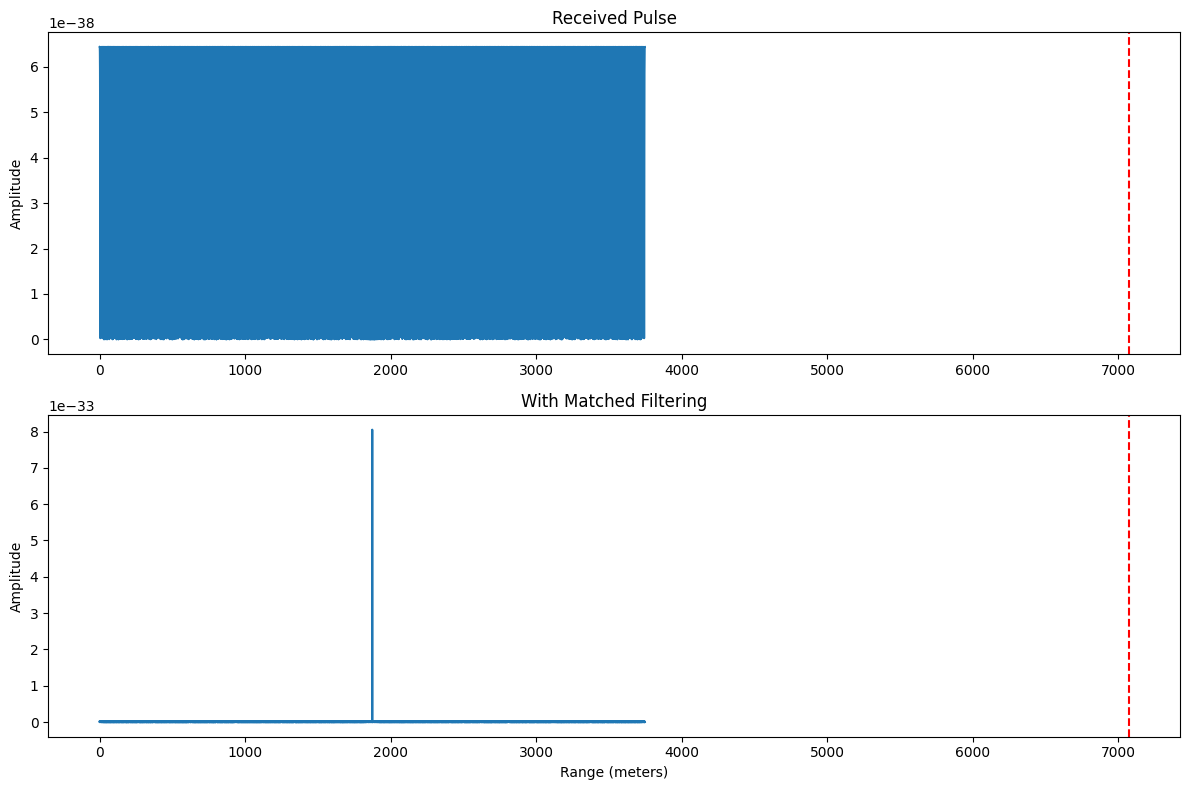

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi, Boltzmann
from scipy.signal import correlate, chirp

# Constants
fc = 10e9  # Carrier frequency
gain = 20  # Transmitter gain in dB
tx_loc = np.array([0, 0, 0])
tgt_loc = np.array([5000, 5000, 10])
pulse_width = 25e-6
prf = 10e3
num_pulses = 1
Ts = 290  # System temperature in Kelvin

# Calculate range and angle from transmitter to target
tgtrng = np.linalg.norm(tgt_loc - tx_loc)
tgtang = np.arctan2(tgt_loc[1], tgt_loc[0])

# Waveform generation
time = np.linspace(0, pulse_width, int(pulse_width * fc))
waveform = chirp(time, f0=0, f1=fc, t1=pulse_width, method='linear')

# Radar equation components
lambda_wave = c / fc
maxrange = c / (2 * prf)
snr = 10 * np.log10(1e-6)  # Simplified SNR calculation for threshold
db_terms = 10**(snr / 10)
Pt = (4 * pi)**3 * Boltzmann * Ts / (pulse_width * 1 / lambda_wave**2 * maxrange**4 * db_terms)  # Peak power estimate

# Simulate transmission and reception
tx_signal = waveform * Pt * 10**(gain / 10)

# Free space path loss model
def free_space_loss(signal, distance, freq):
    wavelength = c / freq
    loss = (4 * pi * distance / wavelength)**2
    return signal / loss

# Transmitting and receiving the signal
propagated_signal = free_space_loss(tx_signal, tgtrng, fc)
received_signal = propagated_signal  # Assume perfect reflection for simplicity

# Matched filtering
matched_filter = np.conj(np.flipud(waveform))
mf_output = correlate(received_signal, matched_filter, mode='same')

# Calculate range gates
sample_rate = int(fc)
gate_time = np.arange(len(received_signal)) / sample_rate
range_gates = gate_time * c / 2

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range_gates, np.abs(received_signal))
plt.title('Received Pulse')
plt.ylabel('Amplitude')
plt.axvline(x=tgtrng, color='r', linestyle='--')

plt.subplot(2, 1, 2)
plt.plot(range_gates, np.abs(mf_output))
plt.title('With Matched Filtering')
plt.xlabel('Range (meters)')
plt.ylabel('Amplitude')
plt.axvline(x=tgtrng, color='r', linestyle='--')

plt.tight_layout()
plt.show()


## Matched Filter

C:\Users\24365\AppData\Roaming\Python\Python312\site-packages\scipy\signal\windows\_windows.py:1821: RuntimeWarning: invalid value encountered in arccosh
  A = np.arccosh(B) / np.pi


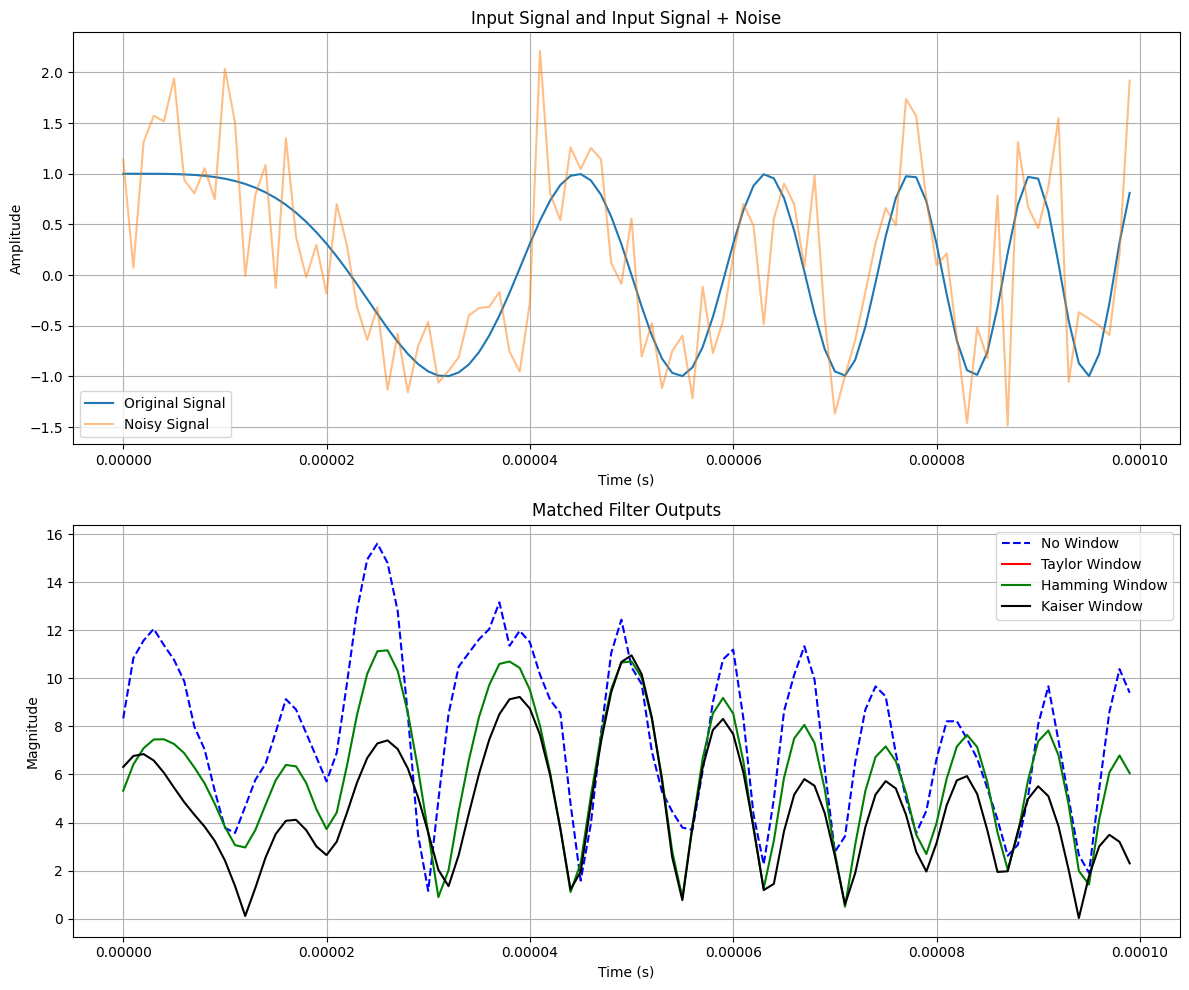

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, correlate, windows

# Parameters
pulse_width = 1e-4
prf = 5e3
sample_rate = 1e6
sweep_bandwidth = 1e5

# Time base
t = np.linspace(0, pulse_width, int(pulse_width * sample_rate), endpoint=False)

# Generate LFM waveform
signal = chirp(t, f0=0, f1=sweep_bandwidth, t1=pulse_width, method='linear')

# Get matched filter (time-reversed complex conjugate of the signal)
matched_filter_coeff = np.conj(signal[::-1])

# Define window functions for matched filter
taylor_win = windows.taylor(len(matched_filter_coeff), nbar=4, sll=-30)
hamming_win = windows.hamming(len(matched_filter_coeff))
kaiser_win = windows.kaiser(len(matched_filter_coeff), beta=14)

# Apply window functions to the matched filter coefficients
taylor_filter_coeff = matched_filter_coeff * taylor_win
hamming_filter_coeff = matched_filter_coeff * hamming_win
kaiser_filter_coeff = matched_filter_coeff * kaiser_win

# Generate noisy LFM waveform
np.random.seed(17)
noise = 0.5 * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
noisy_signal = signal + noise

# Function to apply matched filter
def apply_matched_filter(input_signal, filter_coeff):
    return correlate(input_signal, filter_coeff, mode='same')

# Apply matched filters
filtered_signal = apply_matched_filter(noisy_signal, matched_filter_coeff)
filtered_signal_taylor = apply_matched_filter(noisy_signal, taylor_filter_coeff)
filtered_signal_hamming = apply_matched_filter(noisy_signal, hamming_filter_coeff)
filtered_signal_kaiser = apply_matched_filter(noisy_signal, kaiser_filter_coeff)

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(211)
plt.plot(t, np.real(signal), label='Original Signal')
plt.plot(t, np.real(noisy_signal), label='Noisy Signal', alpha=0.5)
plt.title('Input Signal and Input Signal + Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.plot(t, np.abs(filtered_signal), 'b--', label='No Window')
plt.plot(t, np.abs(filtered_signal_taylor), 'r-', label='Taylor Window')
plt.plot(t, np.abs(filtered_signal_hamming), 'g-', label='Hamming Window')
plt.plot(t, np.abs(filtered_signal_kaiser), 'k-', label='Kaiser Window')
plt.title('Matched Filter Outputs')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Range and Doppler Estimation

Range Estimate: 2997.92 m
Doppler Shift Estimate: 4453.12 Hz
Speed Estimate: 222.50 m/s


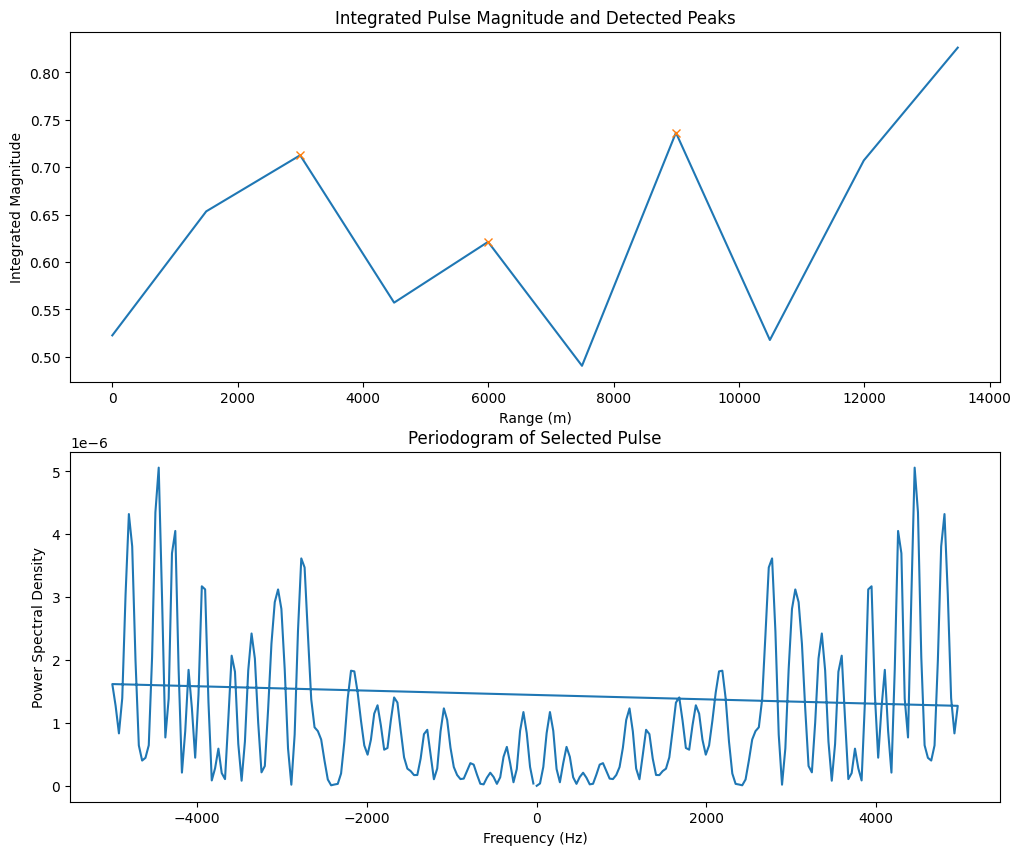

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c, pi, Boltzmann
from scipy.signal import chirp, correlate, find_peaks, periodogram, windows
from scipy.special import erfcinv

# Constants and System Parameters
fc = 3e9  # Carrier frequency (Hz)
fs = 1e6  # Sampling frequency (Hz)
pulse_width = 10e-6
prf = 10e3
sweep_bandwidth = 1e5
num_pulses = 64
tx_loc = np.array([0, 0, 0], dtype=float)
tgt_loc = np.array([5000, 5000, 0], dtype=float)
tgt_vel = np.array([25, 25, 0], dtype=float)  # Target velocity in m/s

# Generate LFM Waveform
t = np.linspace(0, pulse_width, int(pulse_width * fs), endpoint=False)
waveform = chirp(t, f0=0, f1=sweep_bandwidth, t1=pulse_width, method='linear')

# Matched Filter Coefficients (time-reversed complex conjugate of the signal)
matched_filter_coeff = np.conj(np.flip(waveform))

# Simulation of radar signal processing
rx_signal = np.zeros((len(waveform), num_pulses), dtype=complex)

# Radar equation to calculate required transmitter power
Pt = (4 * pi)**3 * Boltzmann * 290 * (c / (2 * prf))**4 * (c / fc)**2 / (pulse_width * 10**(13 / 10))

for n in range(num_pulses):
    # Update target location and velocity with proper time step
    tgt_loc += tgt_vel / prf
    tgtrng = np.linalg.norm(tgt_loc - tx_loc)
    tgtang = np.arctan2(tgt_loc[1], tgt_loc[0])

    # Simulate transmission and reception
    tx_signal = waveform * np.sqrt(Pt) * 10**(20 / 10)
    propagated_signal = tx_signal / (4 * pi * tgtrng / (c / fc))**2  # Simple free space loss model
    rx_signal[:, n] = propagated_signal + 0.1 * np.random.randn(len(waveform))  # Adding noise

# Processing with the matched filter
filtered_signal = np.array([np.correlate(rx_signal[:, n], matched_filter_coeff, mode='same') for n in range(num_pulses)])

# Noise and detection parameters
noise_bandwidth = 5e6 / 2  # Noise bandwidth
k = 1.38e-23  # Boltzmann constant
npower = k * 290 * noise_bandwidth * 10**(0 / 10)  # Noise power

# Detection threshold based on noise power and false alarm rate
thresh = npower * (erfcinv(2 * 1e-6) ** 2) * 2

# Peak detection using find_peaks
pulses_integrated = np.sum(np.abs(rx_signal)**2, axis=1)
peaks, _ = find_peaks(pulses_integrated, height=thresh)

# Range estimation
range_resolution = c / (2 * sweep_bandwidth)
range_bins = np.arange(rx_signal.shape[0]) * range_resolution
if peaks.size > 0:
    range_estimate = range_bins[peaks[0]]
    print(f"Range Estimate: {range_estimate:.2f} m")
else:
    print("No target detected within the threshold limit.")

# Doppler processing using the first detected peak
ts = rx_signal[peaks[0], :] if peaks.size > 0 else rx_signal[0, :]  # Use the first peak or first pulse
frequencies, Pxx = periodogram(ts, fs=prf, nfft=256, return_onesided=False)

# Doppler shift and speed estimation
doppler_shift = frequencies[np.argmax(Pxx)]
target_speed = doppler_shift * (c / fc) / 2
print(f"Doppler Shift Estimate: {doppler_shift:.2f} Hz")
print(f"Speed Estimate: {target_speed:.2f} m/s")

# Visualization
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(range_bins, pulses_integrated)
plt.plot(range_bins[peaks], pulses_integrated[peaks], "x")
plt.title('Integrated Pulse Magnitude and Detected Peaks')
plt.xlabel('Range (m)')
plt.ylabel('Integrated Magnitude')

plt.subplot(212)
plt.plot(frequencies, Pxx)
plt.title('Periodogram of Selected Pulse')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.show()